# ROBUST MULTICLASS CLASSIFIER

In [12]:
import numpy
import pandas
import tensorflow
import keras
import datetime
from matplotlib import pyplot
import seaborn
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import tensorflow.keras.backend as K

%matplotlib inline

In [13]:
# DATA PRE-PREPARATION
file_path = '../../../dataset/occurrences.xlsx'

df = pandas.read_excel(file_path)
df = df.drop(["rai", "obm_afeto", "qualificacao"], axis=1)

#REMOVING NULL VALUES
for column in df.columns:
    df.loc[pandas.isnull(df[column])]
    df = df.loc[df[column] != "(null)"]

#TRANSFORMING "data" COLUMN INTO NEW COLUMNS "dia" e "periodo". ALSO TRANSFORMING "tr" COLUMN INTO "tempo_resposta" COLUMN

def day_name(timestamp):
    weekdays = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
    return weekdays[timestamp.weekday()]

def period_of_day(timestamp):
    period = ("Madrugada", "Matutino", "Vespertino", "Noturno")
    # Madrugada 00:00 às 05:59
    # Matutino 06:00 às 11:59
    # Vespertino 12:00 às 17:59
    # Noturno 18:00 às 23:59
    if 0 <= timestamp.hour < 6:
        return period[0]
    elif 6 <= timestamp.hour < 12:
        return period[1]
    elif 12 <= timestamp.hour < 18:
        return period[2]
    elif 18 <= timestamp.hour < 24:
        return period[3]



def response_time(response_time):
    # Muito rápido 0 a 10 minutos
    # Rápido 10 a 15 minutos
    # Médio 15 a 20 minutos
    # Longo 20 a 30 minutos
    # Muito longo 30 a 45 minutos
    # Extremamente longo > 45 minutos

    response_time_metric = ("Muito rápido", "Rápido", "Médio", "Longo", "Muito longo", "Extremamente longo")

    if type(response_time) is datetime.time:

        total_time_in_minutes = response_time.hour*60 + response_time.minute + response_time.second/60

        if 0 <= total_time_in_minutes <= 10:
            return response_time_metric[0]
        elif 10 < total_time_in_minutes <= 15:
            return response_time_metric[1]
        elif 15 < total_time_in_minutes <= 20:
            return response_time_metric[2]
        elif 20 <  total_time_in_minutes <= 30:
            return response_time_metric[3]
        elif 30 < total_time_in_minutes <= 45:
            return response_time_metric[4]
        elif total_time_in_minutes > 45:
            return response_time_metric[5]
        
#Lembrar de remover os valores que não são datetime.time do df["tr"]
df.loc[:, "dia"] = df["data"].apply(day_name)
df.loc[:, "periodo"] = df["data"].apply(period_of_day)
df.loc[:, "tempo_resposta"] = df["tr"].apply(response_time)

#REMOVING "DATA" AND "TR" COLUMNS

df = df.drop(["data", "tr"], axis=1).loc[0:1000,:] 

#Removing None values
df = df.dropna()
df = df.mask(df.eq('None')).dropna()
df = df.astype(str)
df

/home/higoreller/miniconda3/envs/condaenv/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Cell F221384 is marked as a date but the serial value -736954.9663425926 is outside the limits for dates. The cell will be treated as an error.
  for idx, row in parser.parse():


,naturezas,bairro_cidade,recurso,obm_escala,sexo,dia,periodo,tempo_resposta
5,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->ACIDENT...,ZONA RURAL - CATALÃO,UR-181,10º BBM - CATALÃO,MASCULINO,Domingo,Madrugada,Muito rápido
6,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ABT-26,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
7,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,ASA-74,1º BBM - SETOR CENTRAL,NÃO-INFORMADO,Domingo,Madrugada,Longo
8,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,UR-211,CAEBM,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
9,RESGATE (3)->ACIDENTE DE TRÂNSITO (301)->CAPOT...,ZONA RURAL - NOVA VENEZA,USA-21,BSE,NÃO-INFORMADO,Domingo,Madrugada,Muito longo
...,...,...,...,...,...,...,...,...
993,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->OUTRO /...,CENTRO - MINAÇU,UR-194,1ª CIBM - MINAÇU,FEMININO,Terça-feira,Madrugada,Extremamente longo
995,RESGATE (3)->EMERGÊNCIA CLÍNICA (304)->OUTRO /...,SETOR NORDESTE - FORMOSA,UR-199,CIBM DE FORMOSA - INATIVA,FEMININO,Terça-feira,Matutino,Muito rápido
997,RESGATE (3)->INTOXICAÇÃO EXÓGENA (306)->ALCOOL...,VILA LIONS - GOIÁS,UR-220,12º BBM - GOIÁS,MASCULINO,Terça-feira,Matutino,Muito rápido
998,RESGATE (3)->ACIDENTE ESPORTIVO (302)->FUTEBOL...,CENTRO - ARUANÃ,UR-192,1º PBM - ARUANÃ,MASCULINO,Terça-feira,Matutino,Muito rápido


## INPUT PARAMETERS HERE

In [14]:
# COOK PARAMETERS
var_types = {'naturezas' : 'str',
             'bairro_cidade' : 'str',
             'recurso' : 'str',
             'dia': 'str',
             'periodo': 'str',
             'tempo_resposta': 'str',
             'obm_escala': 'str',
             }
class_col = 'tempo_resposta'
my_metric = 'accuracy'
relevant_features = 2
my_patience = 60
min_improvement = 0.010
min_neuron_gain = 0.025
random_seed = 33
n_k_folds = 3
learning_rate = 0.001
hidden_activations = ['linear', 'tanh', 'relu']
output_activation = 'softmax'
rollback_on_no_lower_bound_gain = True

my_optimizers = {'adagrad': tensorflow.keras.optimizers.Adagrad(learning_rate=learning_rate),
                 'rmsprop': tensorflow.keras.optimizers.RMSprop(learning_rate=learning_rate),
                 'adam': tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)}

## CHECK TENSORFLOW GPU

In [15]:
tensorflow.config.list_physical_devices('GPU')

[]

In [16]:
# SCATTER PLOT
#g = seaborn.pairplot(df, hue='tempo_resposta', height=3, diag_kind='kde')
#_ = g.map_lower(seaborn.kdeplot, levels=1, color=".2")

In [17]:
# QUANTIFY REPRESENTATION 
dfn_mi_list = []
dfn_data_list = []
for my_var in var_types.keys():
    if my_var == class_col:
        col_class = 'Y'
    else:
        col_class = 'X'

    if var_types[my_var] == 'float': # NUMERIC DATA
        dfn_mi_list.append((col_class, 'continuous', my_var))
        dfn_data_list.append(df[[my_var]].values)

    elif var_types[my_var] == 'str' and col_class == 'X': # CATEGORICAL DATA
        one_hot = OneHotEncoder(sparse=False)
        var_cat = df[[my_var]].to_numpy()
        one_hot.fit(var_cat)
        df_X = pandas.DataFrame(one_hot.transform(var_cat))
        df_X.columns = one_hot.categories_
        for cat in df_X.columns:
            dfn_mi_list.append((col_class, 'categorical', cat[0]))
            dfn_data_list.append(df_X[[cat]].values)
    
    elif var_types[my_var] == 'str' and col_class == 'Y': # CATEGORICAL DATA
        one_hot = OneHotEncoder(sparse=False)
        df_Y_categorical = df[[class_col]]
        Y_array_categorical = df_Y_categorical.to_numpy()
        one_hot.fit(Y_array_categorical)
        df_Y = pandas.DataFrame(one_hot.transform(Y_array_categorical))
        df_Y.columns = one_hot.categories_
        for cat in df_Y.columns:
            dfn_mi_list.append((col_class, 'categorical', cat[0]))
            dfn_data_list.append(df_Y[[cat]].values)

dfn_mi = pandas.MultiIndex.from_tuples(dfn_mi_list)
dfn = pandas.DataFrame(index=df.index, columns=dfn_mi, data=numpy.concatenate(dfn_data_list, axis=1))
dfn = dfn.sort_index(axis=1)
dfn

X                                                          \
         categorical                                                           
    10ª CIBM - POSSE 10º BBM - CATALÃO 11ª CIBM - URUAÇU 11º BBM - PORANGATU   
5                0.0               1.0               0.0                 0.0   
6                0.0               0.0               0.0                 0.0   
7                0.0               0.0               0.0                 0.0   
8                0.0               0.0               0.0                 0.0   
9                0.0               0.0               0.0                 0.0   
..               ...               ...               ...                 ...   
993              0.0               0.0               0.0                 0.0   
995              0.0               0.0               0.0                 0.0   
997              0.0               0.0               0.0                 0.0   
998              0.0               0.0               0.0                 0.0   
999              0.0               0.0               0.0                 0.0   

                                                          \
                                                           
    12ª CIBM - MORRINHOS 12º BBM - GOIÁS 13º BBM - JATAÍ   
5                    0.0             0.0             0.0   
6                    0.0             0.0             0.0   
7                    0.0             0.0             0.0   
8                    0.0             0.0             0.0   
9                    0.0             0.0             0.0   
..                   ...             ...             ...   
993                  0.0             0.0             0.0   
995                  0.0             0.0             0.0   
997                  0.0             1.0             0.0   
998                  0.0             0.0             0.0   
999                  0.0             0.0             0.0   

                                                                              \
                                                                               
    14ª CIBM - PIRES DO RIO 14º BBM - SENADOR CANEDO 15ª CIBM - QUIRINÓPOLIS   
5                       0.0                      0.0                     0.0   
6                       0.0                      0.0                     0.0   
7                       0.0                      0.0                     0.0   
8                       0.0                      0.0                     0.0   
9                       0.0                      0.0                     0.0   
..                      ...                      ...                     ...   
993                     0.0                      0.0                     0.0   
995                     0.0                      0.0                     0.0   
997                     0.0                      0.0                     0.0   
998                     0.0                      0.0                     0.0   
999                     0.0                      1.0                     0.0   

     ...                                     \
     ...                                      
     ... ZONA RURAL - SANTA HELENA DE GOIÁS   
5    ...                                0.0   
6    ...                                0.0   
7    ...                                0.0   
8    ...                                0.0   
9    ...                                0.0   
..   ...                                ...   
993  ...                                0.0   
995  ...                                0.0   
997  ...                                0.0   
998  ...                                0.0   
999  ...                                0.0   

                                                                \
                                                                 
    ZONA RURAL DA 2ª AISP (ÁREA NOROESTE DE GOIÂNIA) - GOIÂNIA   
5                                                  0.0           
6            

## ROBUST COOKING

In [18]:
# SET THE RANDOM SEED
numpy.random.seed(random_seed)
tensorflow.random.set_seed(random_seed)

# PREPARE DATA
X = dfn['X'].to_numpy()
my_vars = list(dfn['X'].columns.get_level_values(1))
Y = dfn['Y'].to_numpy()


# NORMALIZE VARIABLES X
X_scaler = StandardScaler()
X_scaler = X_scaler.fit(X)
X_scaled = X_scaler.transform(X)

# NORMALIZE VARIABLES Y
Y_scaler = StandardScaler()
Y_scaler = Y_scaler.fit(Y)
Y_scaled = Y_scaler.transform(Y)

# GET STRATIFIED FOLDS
sk_folds = StratifiedKFold(n_splits=n_k_folds)
sk_folds.get_n_splits(X_scaled, Y_array_categorical)

# TRAINING LOOP
n_classes = df_Y.columns.shape[0]
hidden_layers = 1

# PATTERN SEARCH
search_vector = numpy.identity(len(hidden_activations), dtype=int)
current_configurations = search_vector

still_searching = True
best_net_name = None
best_net = None
best_config = None
best_metric = 0.0
best_metric_val = 0.0
metric_lower_bound = 0.0
result_list = []

print('COOKING BEST NETWORK STARTED...\n')
while still_searching:
    for net_config in current_configurations:
        print('CONFIG: {}'.format(net_config))
        ix_fold = 1
        for train_index, test_index in sk_folds.split(X_scaled, Y_array_categorical):
            print('FOLD: {}/{}'.format(ix_fold, n_k_folds))

            # GET STRATIFIED DATA
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            Y_train, Y_test = Y[train_index], Y[test_index]
            for optimizer in my_optimizers.keys():

                # DECLARE NET
                inputs = keras.Input(shape=(X_train.shape[1], ))
                hidden_layer_list = []
                net_name = ''
                for ix_activation in numpy.arange(len(net_config)):
                    f_activation = hidden_activations[ix_activation]
                    n_neuron = net_config[ix_activation]
                    if n_neuron > 0:
                        temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                        hidden_layer_list.append(temp_hidden_layer)
                        net_name += '{}{}'.format(f_activation, n_neuron)
                if len(hidden_layer_list) > 1:
                    hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                else:
                    hidden = hidden_layer_list[0]
                outputs = keras.layers.Dense(n_classes, activation=output_activation)(hidden)
                model_name = '{}_{}_F{}_WRAPPER'.format(net_name.upper(), optimizer.upper(), ix_fold)
                my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=my_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max',
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT WRAPPER
                with tensorflow.device('/gpu:0'):
                    history = my_net.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=X_train.shape[0], 
                                         epochs=10*my_patience, verbose=0, callbacks=[es_loss, es_metric, es_val_metric])

                # CALCULATE VARIABLE RELEVANCE
                Y_est = my_net.predict(X_scaled)
                relevance_dict = {}
                for feature in my_vars:
                    X_relevance = numpy.copy(X_scaled)
                    X_relevance[:, my_vars == feature] = 0.0
                    Y_est_relevance = my_net.predict(X_relevance)
                    Y_relevance = (Y_est - Y_est_relevance)**2
                    feature_relevance = Y_relevance.sum()/Y_relevance.shape[0]
                    relevance_dict[feature] = feature_relevance
                s_relevance = pandas.Series(relevance_dict)
                s_relevance_norm = s_relevance/s_relevance.max()
                s_relevance_norm = s_relevance_norm.sort_values(ascending=False).head(relevant_features)
                selected_features = list(s_relevance_norm.index.values)
                selected_relevance = list(100.0*s_relevance_norm.values)
                
                
                # FINAL NET
                inputs = keras.Input(shape=(len(selected_features), ))
                hidden_layer_list = []
                net_name = ''
                for ix_activation in numpy.arange(len(net_config)):
                    f_activation = hidden_activations[ix_activation]
                    n_neuron = net_config[ix_activation]
                    if n_neuron > 0:
                        temp_hidden_layer = keras.layers.Dense(n_neuron, activation=f_activation)(inputs)
                        hidden_layer_list.append(temp_hidden_layer)
                        net_name += '{}{}'.format(f_activation, n_neuron)
                if len(hidden_layer_list) > 1:
                    hidden = keras.layers.Concatenate(axis=1)(hidden_layer_list)
                else:
                    hidden = hidden_layer_list[0]
                outputs = keras.layers.Dense(n_classes, activation=output_activation)(hidden)
                model_name = '{}_{}_F{}'.format(net_name.upper(), optimizer.upper(), ix_fold)
                my_net = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

                # COMPILE NET
                metric_name = my_metric.lower()
                val_metric_name = 'val_{}'.format(metric_name)
                my_net.compile(optimizer=my_optimizers[optimizer], loss='mse', metrics=[my_metric])
                es_loss = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=my_patience, restore_best_weights=True)
                es_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=metric_name, mode='max', patience=my_patience, min_delta=min_improvement)
                es_val_metric = tensorflow.keras.callbacks.EarlyStopping(monitor=val_metric_name, mode='max',
                                                                        patience=n_k_folds*my_patience, min_delta=min_improvement)

                # FIT FINAL
                
                ix_relevant = dfn['X'].columns.get_level_values(1).isin(selected_features)
                with tensorflow.device('/gpu:0'):
                    history = my_net.fit(X_train[:, ix_relevant], Y_train, validation_data=(X_test[:, ix_relevant], Y_test), batch_size=X_train.shape[0],
                                        epochs=10*my_patience, verbose=1, callbacks=[es_loss, es_metric, es_val_metric])

                # UNPACK TRAINING RESULTS
                model_loss = history.history['loss'][-1]
                model_val_loss = history.history['val_loss'][-1]
                metric_val = history.history[metric_name][-1]
                val_metric_val = history.history[val_metric_name][-1]
                n_epochs = len(history.history['val_loss'])

                # CHECK IF BEST NET
                best_net_txt = ''
                is_best = False
                if ((metric_val > best_metric + min_improvement) & (val_metric_val >= best_metric_val)) | ((metric_val >= best_metric) & (val_metric_val > best_metric_val + min_improvement)):
                    best_net_name = model_name
                    best_optimizer = optimizer
                    best_config = net_config
                    best_features = selected_features
                    best_net = my_net
                    best_neurons = n_neuron
                    best_metric = metric_val
                    best_metric_val = val_metric_val
                    best_net_txt = '**Best NET!**'
                    is_best = True

                result_dict = {'model_name': model_name, 'optimizer': optimizer, 'net_config': net_config, 'neurons': net_config.sum(), 'fold': ix_fold, 'features': selected_features, 'relevance': selected_relevance, 'loss': model_loss,
                    'val_loss': model_val_loss, metric_name: metric_val, val_metric_name: val_metric_val, 'epochs': n_epochs, 'is_best': is_best, 'net': my_net}
                result_list.append(result_dict)
                if is_best:
                    print('{}_{} > epochs: {} loss: {:.2f} val_loss: {:.2f} {}: {:.0f}% {}: {:.0f}% {}'.format(model_name,'_'.join(selected_features), n_epochs, model_loss, model_val_loss, metric_name, 100.0*metric_val, val_metric_name, 100.0*val_metric_val, best_net_txt))

                # IF MAXIMIZED METRICS BREAK
                maximized_metrics = (val_metric_val == 1.0) & (metric_val == 1.0)
                if maximized_metrics:
                    break
            
            if maximized_metrics:
                break

            ix_fold += 1

        if maximized_metrics:
            break

    # TEST IF MORE NEURONS ARE NECESSARY
    dont_need_extra_neurons = False
    total_neurons = net_config.sum()

    if total_neurons > 1:
        
        # INCREASING NEURONS DIDNT ACHIEVE BEST NET
        if best_neurons < total_neurons:
            dont_need_extra_neurons = True
            print('NETs w {} neurons didnt improve {}!'.format(total_neurons, metric_name))
            break
    
    # CALCULATE CONFIG LOWER BOUND
    df_results = pandas.DataFrame(result_list)
    ix_config = numpy.array([numpy.linalg.norm(best_config - x) for x in df_results.net_config]) == 0.0
    lower_bound_est = df_results[(df_results.optimizer == best_optimizer) & ix_config][val_metric_name].min()

    # TEST IF LOWER BOUND IMPROVED
    lower_bound_didnt_improve = False
    if total_neurons > 1:
        neuron_gain = 0.0
        if lower_bound_est > metric_lower_bound:
            if metric_lower_bound > 0.0:
                neuron_gain = lower_bound_est/metric_lower_bound - 1.0
                if neuron_gain <= min_neuron_gain:
                    print('NETs w {} neurons didnt improve min {} {:.1f} neuron gain {:.1f} / min {:.1f}!'.format(total_neurons, val_metric_name, 100.0*lower_bound_est, 100.0*neuron_gain, 100.0*min_neuron_gain))
                    lower_bound_didnt_improve = True
                    break
                else:
                    print('NETs Neuron Gain w/ {} neurons: {:.1f} >> {:.1f} = {:.2f}%'.format(total_neurons, 100.0*metric_lower_bound, 100.0*lower_bound_est ,100.0*neuron_gain))
            else:
                print('NET Neural Gain From 0.0 >> {:.1f}%'.format(100.0*lower_bound_est))
        else:
            print('No Lower Bound Gain on {} neurons for {}: {:.1f} >> {:.1f}'.format(total_neurons, best_optimizer, 100.0*metric_lower_bound, 100.0*lower_bound_est))
            lower_bound_didnt_improve = True
            break
    else:
        print('BEST CONFIG {} & min quality for {}: {:.1f}%'.format(best_config, best_optimizer.upper(), 100.0*lower_bound_est))
    
    metric_lower_bound = lower_bound_est

    # ALTER CONFIG FROM BEST CONFIG IF NEEDED
    if maximized_metrics or dont_need_extra_neurons or lower_bound_didnt_improve:
        still_searching = False
    else:
        current_configurations = best_config + search_vector

COOKING BEST NETWORK STARTED...

CONFIG: [1 0 0]
FOLD: 1/3
Epoch 1/600
1/1 [==============================] - 0s 311ms/step - loss: 0.1433 - accuracy: 0.3150 - val_loss: 0.1419 - val_accuracy: 0.3171
Epoch 2/600
1/1 [==============================] - 0s 71ms/step - loss: 0.1433 - accuracy: 0.3150 - val_loss: 0.1419 - val_accuracy: 0.3171
Epoch 3/600
1/1 [==============================] - 0s 74ms/step - loss: 0.1433 - accuracy: 0.3150 - val_loss: 0.1419 - val_accuracy: 0.3171
Epoch 4/600
1/1 [==============================] - 0s 60ms/step - loss: 0.1433 - accuracy: 0.3150 - val_loss: 0.1419 - val_accuracy: 0.3171
Epoch 5/600
1/1 [==============================] - 0s 54ms/step - loss: 0.1433 - accuracy: 0.3150 - val_loss: 0.1419 - val_accuracy: 0.3171
Epoch 6/600
1/1 [==============================] - 0s 49ms/step - loss: 0.1433 - accuracy: 0.3150 - val_loss: 0.1419 - val_accuracy: 0.3171
Epoch 7/600
1/1 [==============================] - 0s 72ms/step - loss: 0.1433 - accuracy: 0.3150 - 

In [19]:
# ROLL BACK TO LESS NEURON IF DIDNT IMPROVE
if lower_bound_didnt_improve and rollback_on_no_lower_bound_gain:
    best_row = df_results[(df_results.neurons == n_neuron - 1) & df_results.is_best].tail(1)
    best_net_name = best_row['model_name'].values[0]
    best_optimizer = best_row['optimizer'].values[0]
    best_net = best_row['net'].values[0]
    best_config = best_row['net_config'].values[0]
    best_features = best_row['features'].values[0]
    best_neurons = best_row['neurons'].values[0]
    best_metric = best_row[metric_name].values[0]
    best_metric_val = best_row[val_metric_name].values[0]

print('BEST_NET_NAME: {} \n, BEST_OPTIMIZER: {} \n, BEST_NET: {} \n, BEST_CONFIG: {} \n, BEST_FEATURES: {} \n, BEST_NEURONS: {} \n, BEST_METRIC: {} \n, BEST_METRIC_VAL: {} \n,'.format(best_net_name, best_optimizer, best_net, best_config, best_features, best_neurons, best_metric, best_metric_val))

BEST_NET_NAME: LINEAR1_RMSPROP_F2 
, BEST_OPTIMIZER: rmsprop 
, BEST_NET: <keras.engine.functional.Functional object at 0x7f0002a2f4c0> 
, BEST_CONFIG: [1 0 0] 
, BEST_FEATURES: ['10ª CIBM - POSSE', '10º BBM - CATALÃO'] 
, BEST_NEURONS: 0 
, BEST_METRIC: 0.3516819477081299 
, BEST_METRIC_VAL: 0.3414634168148041 
,


In [20]:
# CLASS COLOR GRID & CLASS EVALUATION
grid_n_points = 100
little_delta = 0.1
jitter_factor = 0.1
rect_expansion = 1.1

# X0 W JITTER
X_plot = df_X[best_features].to_numpy()

x0_grid = numpy.linspace(0, rect_expansion*(X_plot[:, 0].max()), grid_n_points)
x0_jitter = jitter_factor*(x0_grid[1] - x0_grid[0])
x1_grid = numpy.linspace(0, rect_expansion*(X_plot[:, 1].max()), grid_n_points)
x1_jitter = jitter_factor*(x1_grid[1] - x1_grid[0])
X_g = numpy.array(list(itertools.product(x0_grid, x1_grid)))
X_g[:, 0] += x0_jitter*numpy.random.randn(X_g.shape[0])
X_g[:, 1] += x1_jitter*numpy.random.randn(X_g.shape[0])
X_g_scaled = StandardScaler().fit_transform(X_g)
Y_g = best_net.predict(X_g_scaled)
Y_g_class = numpy.array([df_Y.columns[x][0] for x in numpy.argmax(Y_g, axis=1)])

# CLASSIFY DATA
ix_best_features = dfn['X'].columns.isin(best_features, level=1)
Y_est = best_net.predict(X_scaled[:, ix_best_features])
Y_class_est = numpy.array([df_Y.columns[x][0] for x in numpy.argmax(Y_est, axis=1)])
# t_error, t_statistic = best_net.evaluate(X_scaled[:, ix_best_features], Y, verbose=0)

ix_missclass = df_Y_categorical[class_col].to_numpy() != Y_class_est
missclass = X_plot[ix_missclass]
x_0_miss = missclass[:, 0]
x_1_miss = missclass[:, 1]

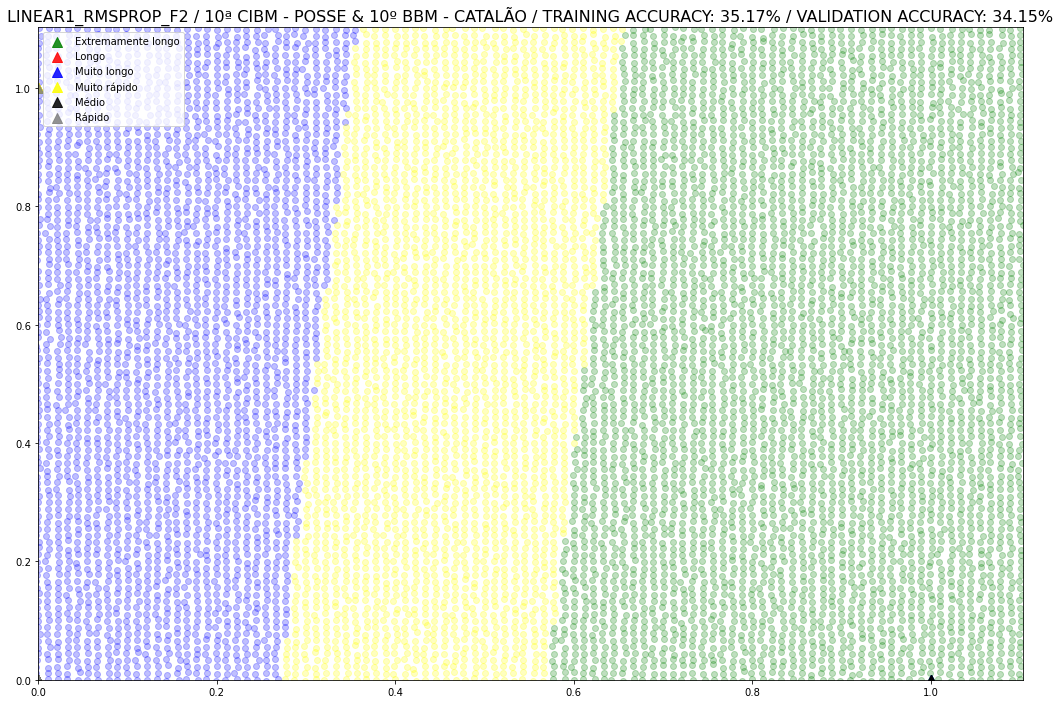

In [21]:
# CLASSIFICATION FIGURE
fig = pyplot.figure(figsize=(12/0.68, 12))
ax = fig.add_subplot(111)

color_list = ['green', 'red', 'blue', 'yellow', 'black', 'gray']

# GIVE COLOURS TO CLASS
color_dict = {}
ix_color = 0
for yclass in df_Y.columns:
    color_dict[yclass[0]] = color_list[ix_color]
    ix_color += 1

# PLOT CLASS REGION
for yclass in df_Y.columns:
    ix_class_cloud = Y_g_class == yclass[0]
    x_0_cloud = X_g[ix_class_cloud, 0]
    x_1_cloud = X_g[ix_class_cloud, 1]
    _ = ax.scatter(x_0_cloud, x_1_cloud, marker='o', color=color_dict[yclass[0]], alpha=0.25)

for yclass in df_Y.columns:
    ix_class = Y_array_categorical.squeeze() == yclass[0]
    x_0 = X_plot[ix_class, 0]
    x_1 = X_plot[ix_class, 1]
    _ = ax.scatter(x_0, x_1, color=color_dict[yclass[0]], marker='^', alpha=0.85, s=100, label=yclass[0])
# _ = ax.scatter(x_0_miss, x_1_miss, color='black', marker='x', alpha=0.85, s=200)
_ = ax.legend()
_ = ax.set_xlim([0.0, X_g[:, 0].max()])
_ = ax.set_ylim([0.0, X_g[:, 1].max()])
_ = ax.set_title('{} / {} / training {}: {:.2f}% / validation {}: {:.2f}%'.format(best_net_name, ' & '.join(best_features), metric_name, 100.0*best_metric, metric_name,100.0*best_metric_val).upper(), size=16)

/tmp/ipykernel_14620/4283074770.py:5: RuntimeWarning: invalid value encountered in divide
  df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['est-{}'.format(x) for x in my_classes], columns=my_classes)


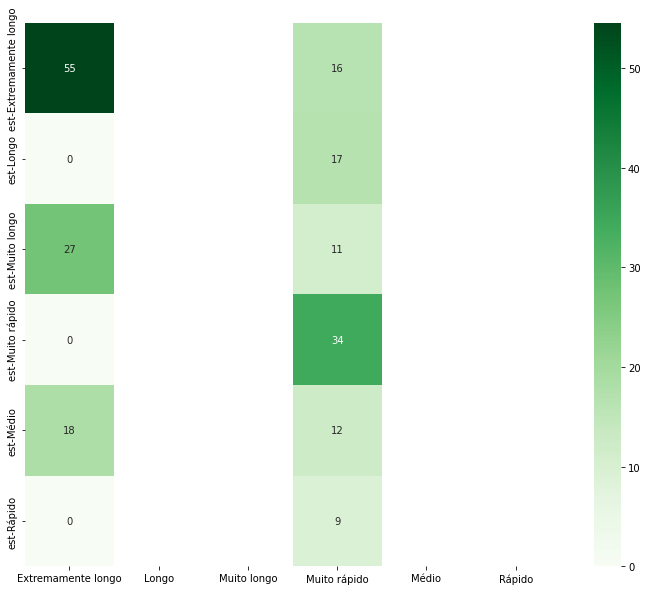

In [22]:
my_classes = [x[0] for x in df_Y.columns.values]

my_conf = confusion_matrix(df_Y_categorical[class_col].to_numpy(), Y_class_est, labels=my_classes)
# df_conf = pandas.DataFrame(my_conf, index=my_classes, columns=['est-{}'.format(x) for x in my_classes])
df_conf = pandas.DataFrame(100.0*my_conf/my_conf.sum(axis=0), index=['est-{}'.format(x) for x in my_classes], columns=my_classes)

fig, ax = pyplot.subplots(figsize=(12,10)) 
_ = seaborn.heatmap(df_conf, cmap="Greens", ax=ax, annot=True, fmt='.0f')